In [108]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
class TransactionHistory:
    """
    Class that will separate transaction history by categories
    """
    def __init__(self):
        self.pool_address = None

        # basic dataframes references
        self.user_in_swap_df = None
        self.user_out_swap_df = None
        self.pool_investments_df = None
        self.pool_extractions_df = None
        self.anomalies_df = None

        # additional dataframes references with moving averages
        self.smaller_avg_in_swap_df = None
        self.bigger_avg_in_swap_df = None
        self.smaller_avg_out_swap_df = None
        self.bigger_avg_out_swap_df = None
        self.smaller_avg_investments_df = None
        self.bigger_avg_investmets_df = None
        self.smaller_avg_exractions_df = None
        self.bigger_avg_extractions_df = None
        self.smaller_avg_anomalies = None
        self.bigger_avg_anomalies = None

    
    def classify_history(self, transactions_df: pd.DataFrame):
        """
        Separate history in different dataframes conform transaction parameters
        ('swapping in/out', 'investments, extractions' and 'anomalies') that
        can be requested as current class object fields
        
        Keyword arguments:
        transactions_df (pandas.DataFrame) -- dataframe with all transactions
            in given pool
        """
        # find address of the pool - most of the transactions will be related to pool
        self.pool_address = transactions_df['From'].mode()[0]
        
        # create matrix of transactions hashes and counters of in/out pool movements
        group_df = transactions_df.groupby('Txhash').agg({
            'From': self.__contract_address_count__,
            'To': self.__contract_address_count__
        })
        
        # form lists of swapping transactions, investments, extractions, anomalies
        swap_txhash_list = group_df[(group_df['From'] == 1) & (group_df['To'] == 1)].index.values
        investments_list = group_df[group_df['To'] == 2].index.values
        extractions_list = group_df[group_df['From'] == 2].index.values
        anomalies_list = group_df[(group_df['From'] > 2) | (group_df['To'] > 2)].index.values

        # record swapping in/out operations
        self.user_in_swap_df = transactions_df[(transactions_df['Txhash'].isin(swap_txhash_list)) & 
                                                (transactions_df['To'] == self.pool_address)]
        self.user_out_swap_df = transactions_df[(transactions_df['Txhash'].isin(swap_txhash_list)) & 
                                                (transactions_df['From'] == self.pool_address)]

        # record investments and extractions
        self.pool_investments_df = transactions_df[transactions_df['Txhash'].isin(investments_list)]
        self.pool_extractions_df = transactions_df[transactions_df['Txhash'].isin(extractions_list)]
        
        # record anomalies
        self.anomalies_df = transactions_df[transactions_df['Txhash'].isin(anomalies_list)]

        
    def __contract_address_count__(self, s):
        return (s == self.pool_address).sum()


    def form_moving_averages_for_token(self, smaller_average: str, bigger_average: str, target_token: str):
        self.smaller_avg_in_swap_df = self.__set_mov_smaller_avg__(
            self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_in_swap_df = self.__set_mov_bigger_avg__(
            self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_out_swap_df = self.__set_mov_smaller_avg__(
            self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_out_swap_df = self.__set_mov_bigger_avg__(
            self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_investments_df = self.__set_mov_smaller_avg__(
            self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_investmets_df = self.__set_mov_bigger_avg__(
            self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_exractions_df = self.__set_mov_smaller_avg__(
            self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_extractions_df = self.__set_mov_bigger_avg__(
            self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_anomalies = self.__set_mov_smaller_avg__(
            self.anomalies_df[self.anomalies_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_anomalies = self.__set_mov_bigger_avg__(
            self.anomalies_df[self.anomalies_df['TokenSymbol'] == target_token], bigger_average)


    def __set_mov_smaller_avg__(self, df: pd.DataFrame, smaller_avg: str) -> pd.DataFrame:
        df_time = df.copy()
        df_time.UnixTimestamp = pd.to_datetime(df_time.UnixTimestamp, unit='s')
        df_time.index = df_time.UnixTimestamp
        return df_time.resample(smaller_avg).mean()

    
    def __set_mov_bigger_avg__(self, df: pd.DataFrame, bigger_avg: str) -> pd.DataFrame:
        df_time = df.copy()
        df_time.UnixTimestamp = pd.to_datetime(df_time.UnixTimestamp, unit='s')
        df_time.index = df_time.UnixTimestamp
        return df_time.rolling(bigger_avg).mean()

# WBTC/USDC

In [197]:
wbtc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\WBTC-USDT_01-10_31-10.csv", index_col=False)
wbtc_df.Value = wbtc_df.Value.str.replace(",", "")
wbtc_df.Value = wbtc_df.Value.astype("float")
wbtc_df['Datetime'] = pd.to_datetime(wbtc_df['UnixTimestamp'], unit='s')

th = TransactionHistory()
th.classify_history(wbtc_df)

## Swapping in/out distributions

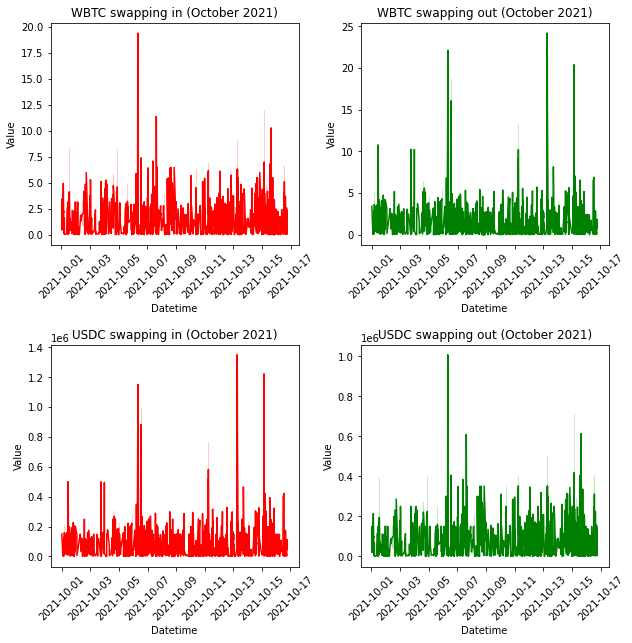

In [228]:
plt.figure(figsize=(10, 10))

# first currency graphs
plt.subplot(2, 2, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.user_in_swap_df[th.user_in_swap_df['TokenSymbol'] == 'WBTC'], 
            x='Datetime', y='Value', color='red').set_title('WBTC swapping in (October 2021)')
plt.subplot(2, 2, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.user_out_swap_df[th.user_out_swap_df['TokenSymbol'] == 'WBTC'], 
            x='Datetime', y='Value', color='green').set_title('WBTC swapping out (October 2021)')

# second currency graphs
plt.subplot(2, 2, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.user_in_swap_df[th.user_in_swap_df['TokenSymbol'] == 'USDC'], 
            x='Datetime', y='Value', color='red').set_title('USDC swapping in (October 2021)')
plt.subplot(2, 2, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.user_out_swap_df[th.user_out_swap_df['TokenSymbol'] == 'USDC'], 
            x='Datetime', y='Value', color='green').set_title('USDC swapping out (October 2021)')

plt.subplots_adjust(hspace=0.45, wspace=0.25)
plt.show()

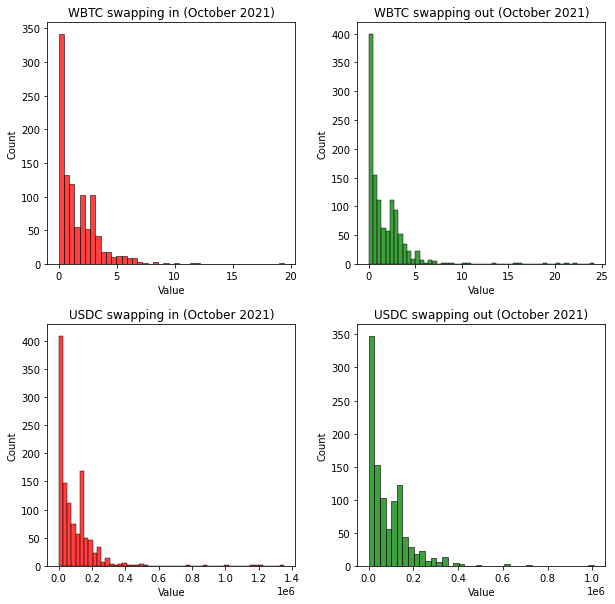

In [225]:
plt.figure(figsize=(10, 10))

# first currency graphs
plt.subplot(2, 2, 1)
sns.histplot(data=th.user_in_swap_df[th.user_in_swap_df['TokenSymbol'] == 'WBTC'],
            x='Value', color='red').set_title('WBTC swapping in (October 2021)')
plt.subplot(2, 2, 2)
sns.histplot(data=th.user_out_swap_df[th.user_out_swap_df['TokenSymbol'] == 'WBTC'],
            x='Value', color='green').set_title('WBTC swapping out (October 2021)')

# second currency graphs
plt.subplot(2, 2, 3)
sns.histplot(data=th.user_in_swap_df[th.user_in_swap_df['TokenSymbol'] == 'USDC'],
            x='Value', color='red').set_title('USDC swapping in (October 2021)')
plt.subplot(2, 2, 4)
sns.histplot(data=th.user_out_swap_df[th.user_out_swap_df['TokenSymbol'] == 'USDC'],
            x='Value', color='green').set_title('USDC swapping out (October 2021)')

plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

## Investments, Extractions and Anomalies

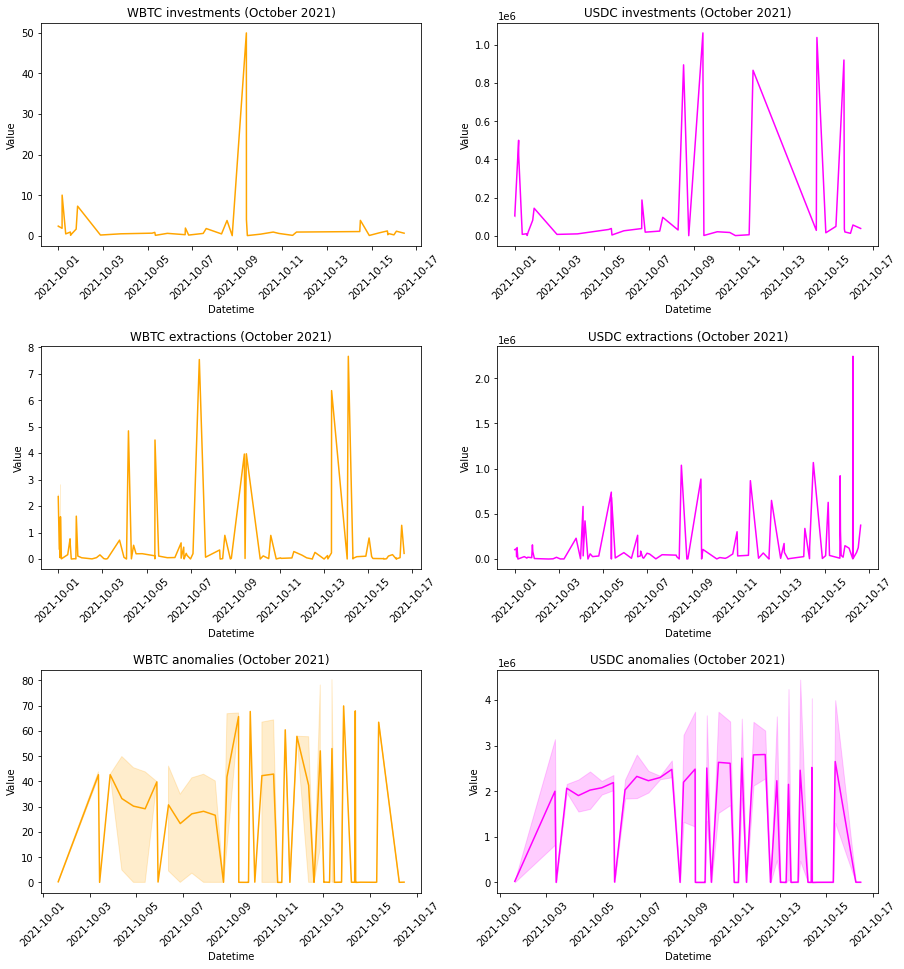

In [230]:
plt.figure(figsize=(15, 16))

# investments
plt.subplot(3, 2, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.pool_investments_df[th.pool_investments_df['TokenSymbol'] == 'WBTC'],
            x='Datetime', y='Value', color='orange').set_title('WBTC investments (October 2021)')
plt.subplot(3, 2, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.pool_investments_df[th.pool_investments_df['TokenSymbol'] == 'USDC'],
            x='Datetime', y='Value', color='magenta').set_title('USDC investments (October 2021)')

# extractions
plt.subplot(3, 2, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.pool_extractions_df[th.pool_extractions_df['TokenSymbol'] == 'WBTC'],
            x='Datetime', y='Value', color='orange').set_title('WBTC extractions (October 2021)')
plt.subplot(3, 2, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.pool_extractions_df[th.pool_extractions_df['TokenSymbol'] == 'USDC'],
            x='Datetime', y='Value', color='magenta').set_title('USDC extractions (October 2021)')

# anomalies
plt.subplot(3, 2, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.anomalies_df[th.anomalies_df['TokenSymbol'] == 'WBTC'],
            x='Datetime', y='Value', color='orange').set_title('WBTC anomalies (October 2021)')
plt.subplot(3, 2, 6)
plt.xticks(rotation=45)
sns.lineplot(data=th.anomalies_df[th.anomalies_df['TokenSymbol'] == 'USDC'],
            x='Datetime', y='Value', color='magenta').set_title('USDC anomalies (October 2021)')

plt.subplots_adjust(hspace=0.45, wspace=0.2)
plt.show()

## Moving averages information

In [198]:
# calling function that will find moving averages for specified token
th.form_moving_averages_for_token('5h', '1D', 'WBTC')

<ipython-input-233-2296604efde7>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 1, 1)
<ipython-input-233-2296604efde7>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 1, 2)
<ipython-input-233-2296604efde7>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

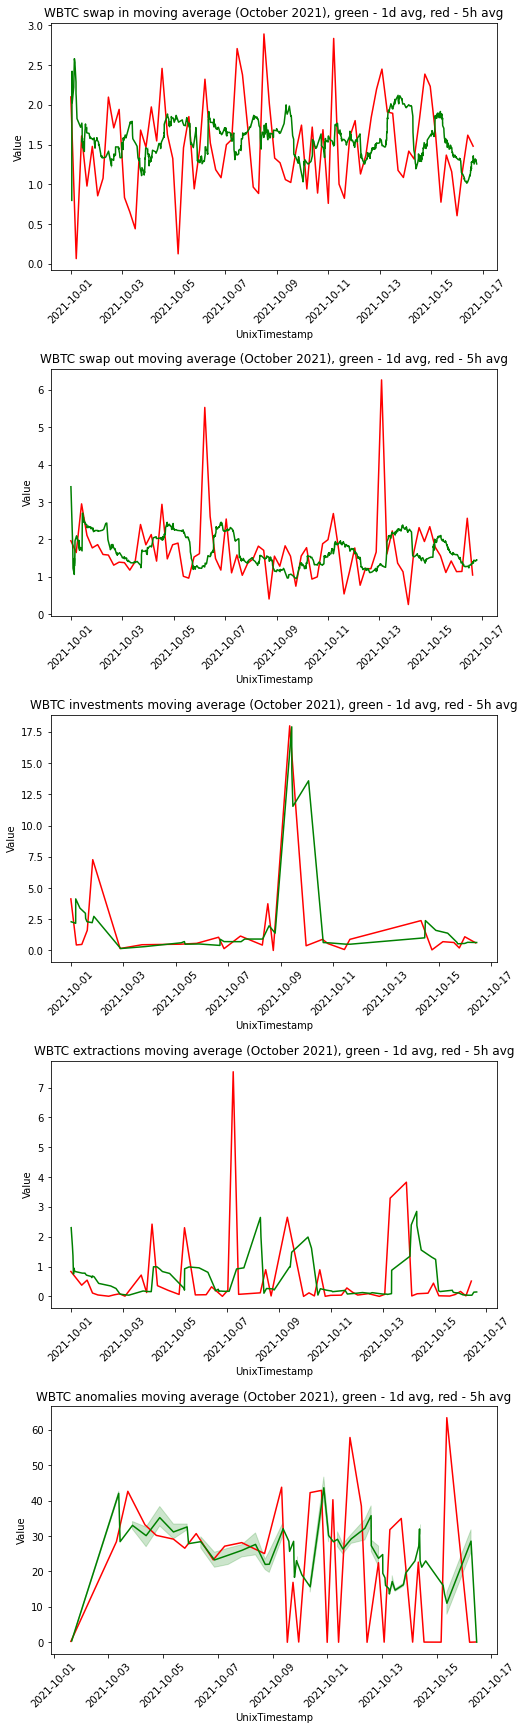

In [233]:
plt.figure(figsize=(8, 30))

plt.subplot(5, 1, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC swap in moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC swap in moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC swap out moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC swap out moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC investments moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC investments moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC extractions moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC extractions moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC anomalies moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC anomalies moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplots_adjust(hspace=0.4, wspace=0.15)
plt.show()

In [234]:
# calling function that will find moving averages for specified token
th.form_moving_averages_for_token('5h', '1D', 'USDC')

<ipython-input-235-c98da76ab88c>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 1, 1)
<ipython-input-235-c98da76ab88c>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 1, 2)
<ipython-input-235-c98da76ab88c>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

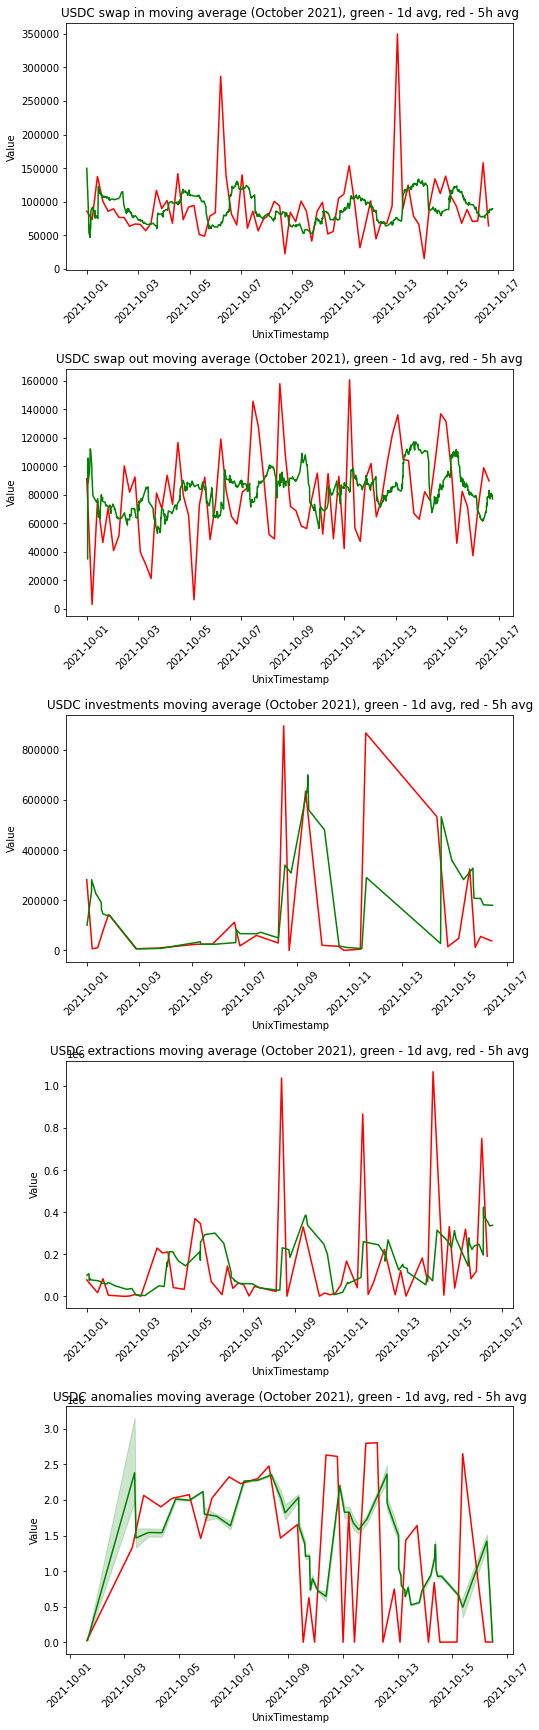

In [235]:
plt.figure(figsize=(8, 30))

plt.subplot(5, 1, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('USDC swap in moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('USDC swap in moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('USDC swap out moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('USDC swap out moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('USDC investments moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('USDC investments moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('USDC extractions moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('USDC extractions moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 1, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='red'
            ).set_title('USDC anomalies moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 1, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='green'
            ).set_title('USDC anomalies moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplots_adjust(hspace=0.4, wspace=0.15)
plt.show()

<ipython-input-237-3d93d1ae0f2a>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 2, 1)
<ipython-input-237-3d93d1ae0f2a>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 2, 3)
<ipython-input-237-3d93d1ae0f2a>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

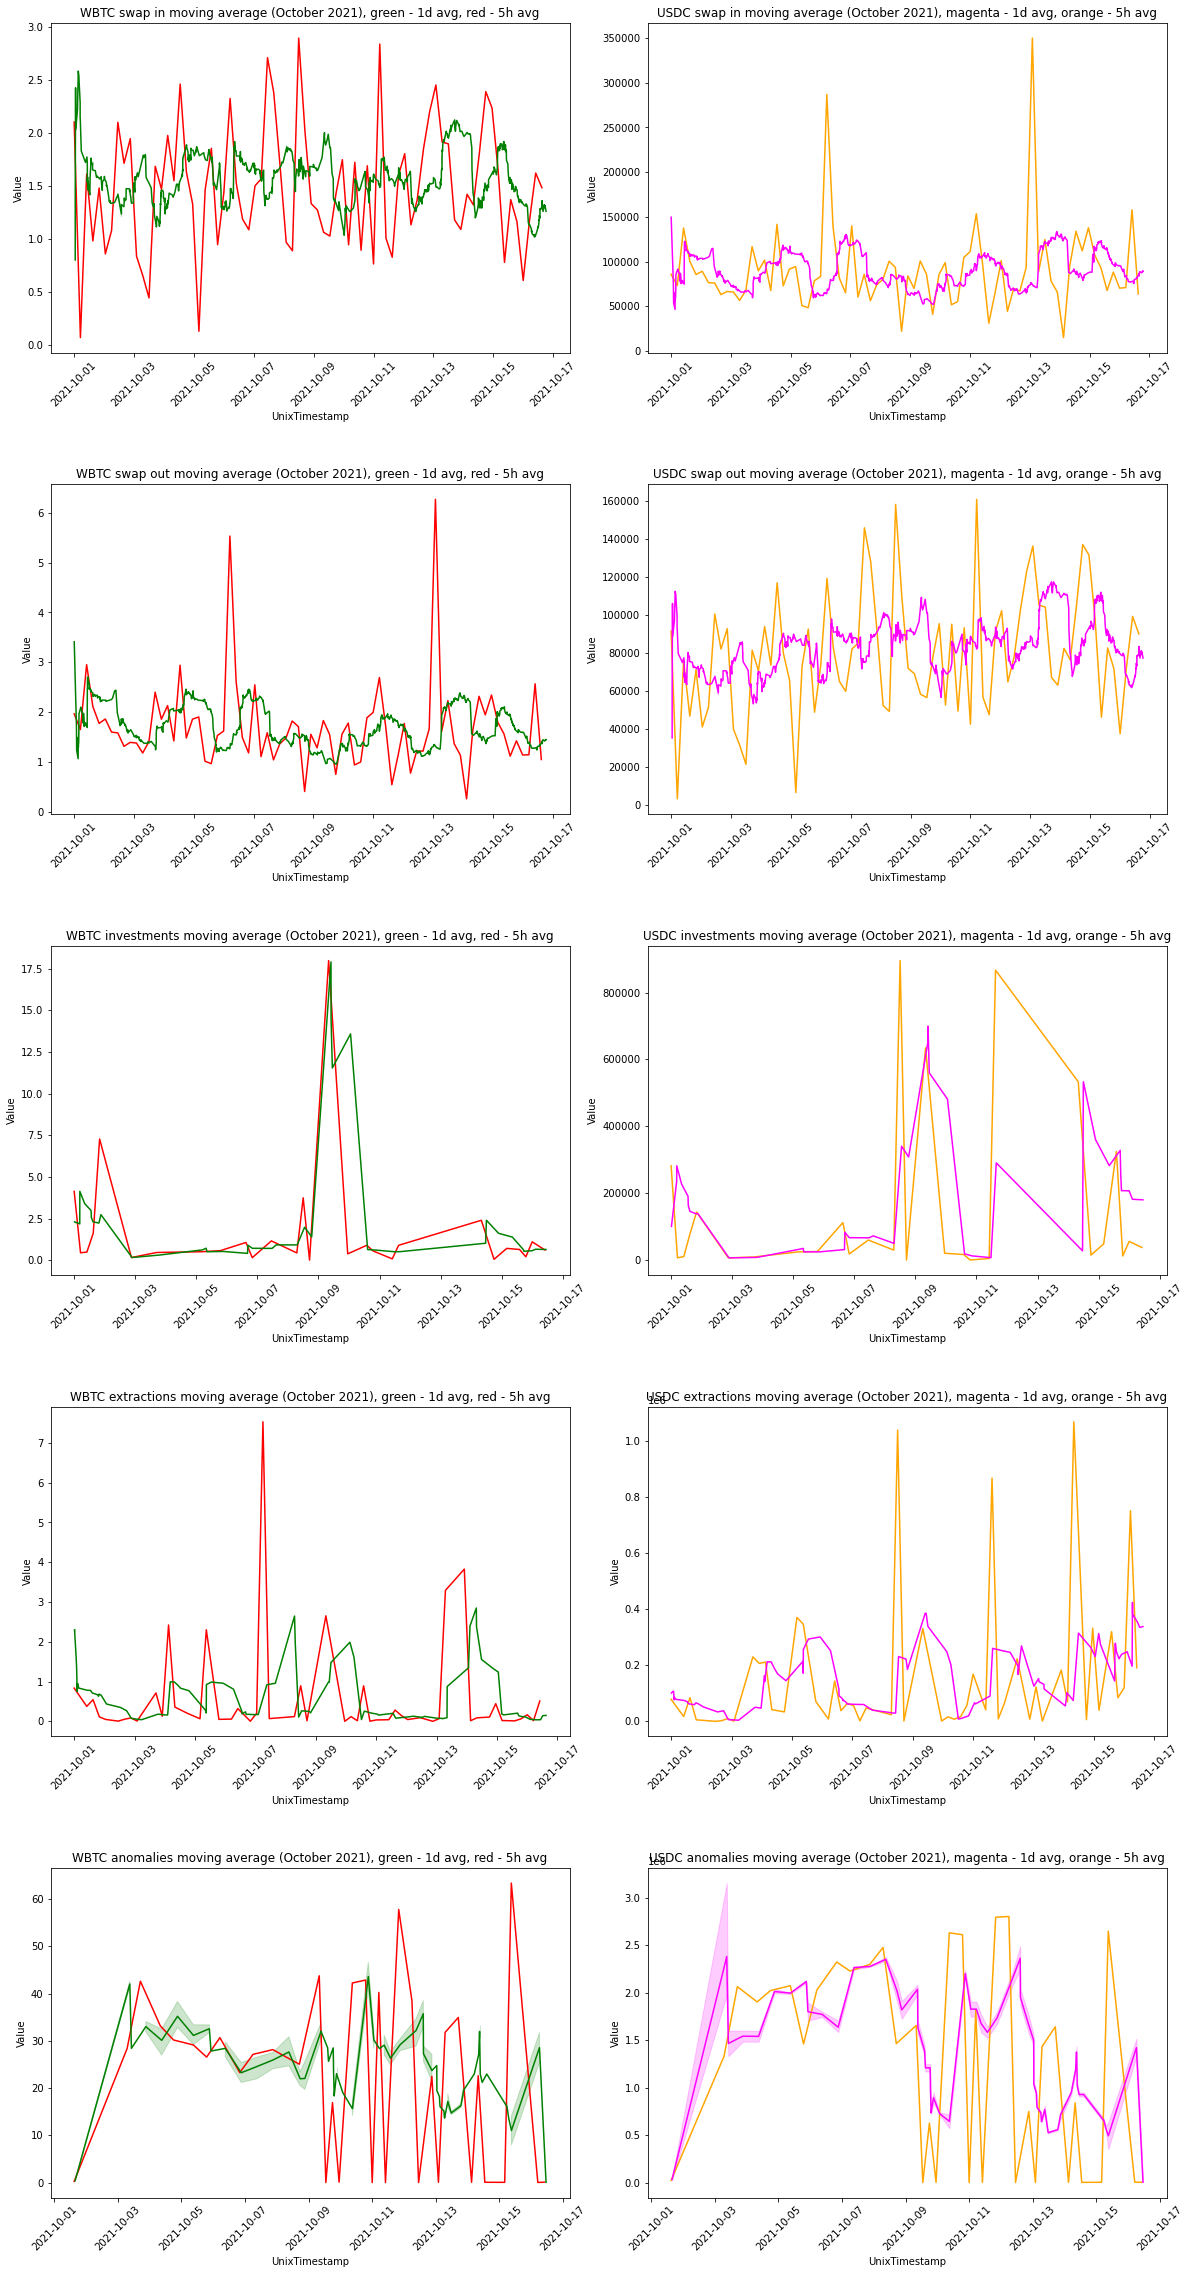

In [237]:
plt.figure(figsize=(20, 40))

th.form_moving_averages_for_token('5h', '1D', 'WBTC')

plt.subplot(5, 2, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC swap in moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 2, 1)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC swap in moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 2, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC swap out moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 2, 3)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC swap out moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 2, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC investments moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 2, 5)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC investments moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 2, 7)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC extractions moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 2, 7)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC extractions moving average (October 2021), green - 1d avg, red - 5h avg')

plt.subplot(5, 2, 9)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='red'
            ).set_title('WBTC anomalies moving average (October 2021), green - 1d avg, red - 5h avg')
plt.subplot(5, 2, 9)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='green'
            ).set_title('WBTC anomalies moving average (October 2021), green - 1d avg, red - 5h avg')

th.form_moving_averages_for_token('5h', '1D', 'USDC')

plt.subplot(5, 2, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='orange'
            ).set_title('USDC swap in moving average (October 2021), magenta - 1d avg, orange - 5h avg')
plt.subplot(5, 2, 2)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='magenta'
            ).set_title('USDC swap in moving average (October 2021), magenta - 1d avg, orange - 5h avg')

plt.subplot(5, 2, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='orange'
            ).set_title('USDC swap out moving average (October 2021), magenta - 1d avg, orange - 5h avg')
plt.subplot(5, 2, 4)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='magenta'
            ).set_title('USDC swap out moving average (October 2021), magenta - 1d avg, orange - 5h avg')

plt.subplot(5, 2, 6)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='orange'
            ).set_title('USDC investments moving average (October 2021), magenta - 1d avg, orange - 5h avg')
plt.subplot(5, 2, 6)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='magenta'
            ).set_title('USDC investments moving average (October 2021), magenta - 1d avg, orange - 5h avg')

plt.subplot(5, 2, 8)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='orange'
            ).set_title('USDC extractions moving average (October 2021), magenta - 1d avg, orange - 5h avg')
plt.subplot(5, 2, 8)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='magenta'
            ).set_title('USDC extractions moving average (October 2021), magenta - 1d avg, orange - 5h avg')

plt.subplot(5, 2, 10)
plt.xticks(rotation=45)
sns.lineplot(data=th.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='orange'
            ).set_title('USDC anomalies moving average (October 2021), magenta - 1d avg, orange - 5h avg')
plt.subplot(5, 2, 10)
plt.xticks(rotation=45)
sns.lineplot(data=th.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='magenta'
            ).set_title('USDC anomalies moving average (October 2021), magenta - 1d avg, orange - 5h avg')

plt.subplots_adjust(hspace=0.4, wspace=0.15)
plt.show()